In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import hyp2f1

In [9]:
data = pd.read_csv('../data/UnderlyingOptionsEODCalcs_2022-09-02.csv')
print(data.columns)

Index(['underlying_symbol', 'quote_date', 'root', 'expiration', 'strike',
       'option_type', 'open', 'high', 'low', 'close', 'trade_volume',
       'bid_size_1545', 'bid_1545', 'ask_size_1545', 'ask_1545',
       'underlying_bid_1545', 'underlying_ask_1545',
       'implied_underlying_price_1545', 'active_underlying_price_1545',
       'implied_volatility_1545', 'delta_1545', 'gamma_1545', 'theta_1545',
       'vega_1545', 'rho_1545', 'bid_size_eod', 'bid_eod', 'ask_size_eod',
       'ask_eod', 'underlying_bid_eod', 'underlying_ask_eod', 'vwap',
       'open_interest', 'delivery_code'],
      dtype='object')


In [11]:
n = 200

repeat = 10000

# Zn1 has shape (repeat, n)
Zn1 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)  # une fois pour tout (invariant by eta and lam)
Zn2 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)

w1 = np.cumsum(Zn1, axis=1)
w2 = np.cumsum(Zn2, axis=1)

In [12]:
# Exp Kernel-Cholesky for XT

def Sigma_exp(t, s, eta, lam):
    return (
        eta**2
        / (2 * lam)
        * np.exp(-lam * (s + t))
        * (np.exp(2 * lam * np.minimum(s, t)) - 1)
    )

def covariance_exp(T, eta, lam):
    '''Return the covariance Sigma for exponential kernel.
    '''
    times = np.linspace(0, T, n + 1)
    cov = np.zeros((n, n))
    for i in range(n):
        cov[i, :] = Sigma_exp(times[1+i], times[1:], eta=eta, lam=lam)
    return cov


In [13]:
# Frac Kernel-XT

def aux_integral_function(x,k,a):
    return x*(k+x**2)**a*((k+x**2)/k)**(-a)*hyp2f1(0.5, -a, 1.5, -x**2/k)

def Sigma_frac(t, s, H, c):
    a = H-0.5
    if t==s:
        return c**2 * 2*(t/2)**(2*a+1)/(2*a+1)
    else:
        k = 0.25*(s-t)**2
        xmin = - 0.5*(s+t)
        xmax = np.minimum(t,s) + xmin
        return c**2 * (aux_integral_function(xmax, k, a) - aux_integral_function(xmin, k, a))

def covariance_frac(T, H, c):
    times = np.linspace(0, T, n + 1)
    cov = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cov[i,j] = Sigma_frac(times[1+i], times[1+j], H=H, c=c)
    return cov


In [14]:

def sample_XT_Cholesky(lam, eta, Zns=Zn1, T=1.5):

    cov = covariance_exp(eta=eta, lam=lam, T=T)
    L = np.linalg.cholesky(cov)
    # t begins from t1=T/n but not t0=0
    sample = Zns @ L.T

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample, cov

def sample_XT_cumsum(lam, eta, Zns=Zn1, T=1.5):
    times = np.linspace(0, T, n + 1)
    sigma = eta * np.sqrt(np.exp(2*lam*times[:-1])*(np.exp(2*lam*T/n)-1)/(2*lam))
    sample = np.exp(-lam*times[1:]) * np.cumsum(Zns*sigma, axis=1)

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample
    

def sample_XT_frac(H, c, Zns=Zn1, T=1.5):

    cov = covariance_frac(T=T, H=H, c=c)
    L = np.linalg.cholesky(cov)
    
    sample =  Zns @ L.T

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_frac(T,T, H, c):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample, cov

In [15]:
%%timeit
sample_XT_cumsum(lam=1, eta=1)

27.9 ms ± 3.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%%timeit
sample_XT_Cholesky(lam=1, eta=1)

20.5 ms ± 5.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
def plot_sample(sample, ylabel="${X_T}$", title=f"Sample of XT with n={n}", save_pic=False):
    T=1.5
    times = np.linspace(0, T, n + 1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(times[1:], sample.T, "-")

    ax.set_xlabel("time t")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()
    if save_pic:
        plt.savefig(title)

In [18]:
def sample_B(rho=0.5, T=1.5):
    sample = rho*np.sqrt(T/n)*w1+np.sqrt(1-rho**2)*np.sqrt(T/n)*w2
    
    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])
    demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"B_T: mean={mean:3.3f} var={var:3.3f} ({T:3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample

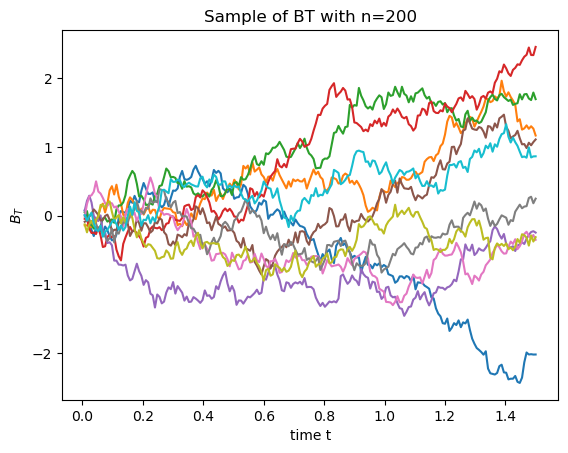

In [19]:
plot_sample(sample_B(rho=0)[:10], ylabel="${B_T}$", title=f"Sample of BT with n={n}")
print("")

In [20]:
def Sigma(X, vars, ksi=0.5, a0=1, a1=1):
    return ksi*(a0 + a1*X) / np.sqrt(a0**2 + a1**2*vars)

In [21]:
def sample_S_exp(rho=0.5, eta=1, lam=1, S0=100, ksi=0.5, a0=1, T=1.5):
    
    X_sample, cov = sample_XT_Cholesky(lam=lam, eta=eta, T=T)
    vars = np.diagonal(cov)

    sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars, ksi=ksi, a0=a0)))
    

    B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho,T=T)))
    sum1 = np.cumsum(0.5*(sigma[:, :-1]**2+sigma[:, 1:]**2)*T/n, axis=1)
    sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
    sample = np.hstack((S0*np.ones(repeat).reshape(-1,1), S0*np.exp(-0.5*sum1+sum2)))
    
    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    # print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
         
    return sample

def sample_S_frac(rho=0.5, H=0.5, c=1, S0=100, ksi=0.5, a0=1, T=1.5):
    
    X_sample, cov = sample_XT_frac(H=H, c=c, T=T)
    vars = np.diagonal(cov)

    sigma = np.hstack((np.zeros(repeat).reshape(-1,1), Sigma(X_sample, vars, ksi=ksi, a0=a0)))

    B_sample =  np.hstack((np.zeros(repeat).reshape(-1,1), sample_B(rho=rho,T=T)))
    sum1 = np.cumsum(0.5*(sigma[:, :-1]**2+sigma[:, 1:]**2)*T/n, axis=1)
    sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
    sample = np.hstack((S0*np.ones(repeat).reshape(-1,1), S0*np.exp(-0.5*sum1+sum2)))
    
    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    # print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
         
    return sample

(10000, 201)


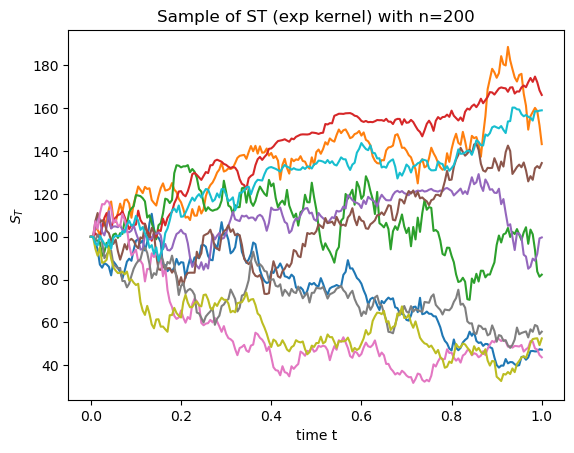

In [22]:
T = 1
times = np.linspace(0, T, n + 1)
sample = sample_S_exp(rho=-0.8, T=T)
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(times, sample[:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (exp kernel) with n={n}")
plt.show()


(10000, 201)


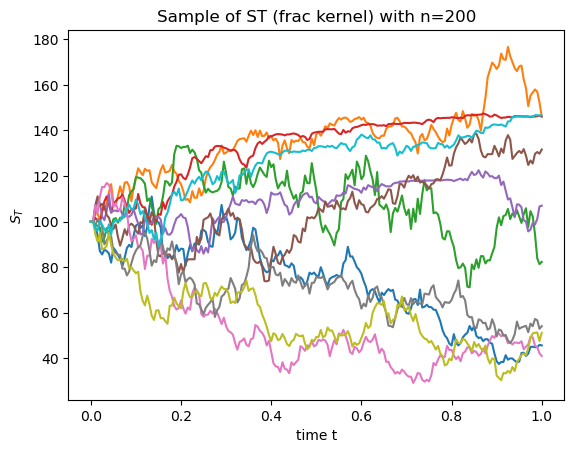

In [23]:
T = 1
times = np.linspace(0, T, n + 1)
sample = sample_S_frac(rho=-0.8, T=T)
print(sample.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(times, sample[:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST (frac kernel) with n={n}")
plt.show()

In [24]:
def call_exp(S0, K, T, rho=0.5, eta=1, lam=1):
    return np.mean(np.maximum(sample_S_exp(rho=rho, eta=eta, lam=lam, S0=S0, T=T)[:,-1]-K, 0))

In [25]:
def call_frac(S0, K, T, rho=0.5, H=0.5, c=1, ksi=0.5, a0=1):
    return float(np.mean(np.maximum(sample_S_frac(rho=rho, H=H, c=c, S0=S0, ksi=ksi, a0=a0, T=T)[:,-1]-K, 0)))

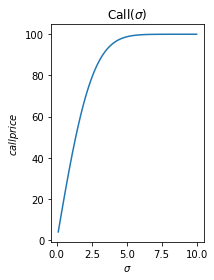

In [312]:
from scipy.stats import norm

# Gaussian distributions, as reference
N_prime = norm.pdf
N = norm.cdf

def black_scholes_call(S, K, T, r, sigma):
    """

    :param S: Asset price
    :param K: Strike price
    :param T: Time to maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: call price
    """

    # standard black-scholes formula
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = S * N(d1) - N(d2) * K * np.exp(-r * T)
    return call

black_scholes_call(S=100, K=100, T=T, r=0, sigma=0.5)

fig = plt.figure()
ax = fig.add_subplot(121)

sigmas = np.linspace(0.1,10,100)
sample = [black_scholes_call(S=100, K=100, T=T, r=0, sigma=sigma) for sigma in sigmas]
ax.plot(sigmas, sample, "-")

ax.set_xlabel("$\sigma$")
ax.set_ylabel("$call price$")
ax.set_title("Call($\sigma$)")


plt.show()

In [319]:
%%time
# Here we calibrate using scipy.optimize for one slice

from scipy.optimize import minimize

# x0 = [-0.75, 0.25, 1, 0.5, 1]
x0 = [-0.7, 0.25, 0.5, 1, 0.5]

bounds = ((-1,-0.5),(0,0.5),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf))

C = call_frac(S0=120, K=100, T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5)

def call_frac_optimize(x, S0=120, K=100, T=1.5):
    ''' Objective function '''
    return np.abs(call_frac(K=K, S0=S0, T=T, rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4]) - C)


res = minimize(call_frac_optimize, x0, method='SLSQP', bounds=bounds)
print(res)

/tmp/ipykernel_5713/1784926477.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  return c**2 * 2*(t/2)**(2*a+1)/(2*a+1)
/tmp/ipykernel_5713/1906855154.py:2: RuntimeWarning: invalid value encountered in true_divide
  return ksi*(a0 + a1*X) / np.sqrt(a0**2 + a1**2*vars)


     fun: 2.025758760737517e-08
     jac: array([ -9.23272371,  13.70430708,  -0.37830639, -26.17344332,
         0.3534708 ])
 message: 'Optimization terminated successfully'
    nfev: 106
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([-0.79829243,  0.30459887,  0.53944004,  1.01584297,  0.5773421 ])
CPU times: user 3min 41s, sys: 5.65 s, total: 3min 46s
Wall time: 41 s


In [31]:
params = [-0.79829243,  0.30459887,  0.53944004,  1.01584297,  0.5773421 ]
print(call_frac(S0=120, K=100, T=1.5, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4]))
print(call_frac(S0=120, K=100, T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5))

56.85315873702313
56.808263887804024


In [36]:
%%time
# Here we calibrate using scipy.optimize for plural slices

from scipy.optimize import least_squares

def loss_frac(x, u, y):
    ''' loss function 
        x: input-x0=K, x1=S0, x2=T
        u: parameters-rho, H, c, ksi, a0
        y: the real call price
    '''
    return np.array([call_frac(K=u[i][0], S0=u[i][1], T=u[i][2], rho=x[0], H=x[1], c=x[2], ksi=x[3], a0=x[4]) - y[i] for i in range(len(y))])

x0 = np.array([-0.7, 0.25, 0.5, 1, 0.5])

bounds = ([-1, 0, 0, 0, 0], [-0.5, 0.5, 2, 2, 2])

u = np.array([[100, 120, 1.5], [100, 100, 1.5], [100, 80, 1.2]])
y = np.array([call_frac(S0=u[i][0], K=u[i][1], T=u[i][2], rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5) for i in range(len(u))])

least_squares(loss_frac, x0, bounds=bounds, args=(u,y), verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.1941e+02                                    3.54e+02    
       1              2         4.5485e+02      6.46e+01       4.77e-01       1.32e+02    
       2              3         4.4788e+02      6.97e+00       1.19e+00       8.25e+00    
       3              6         4.4785e+02      2.64e-02       2.90e-03       2.83e-01    
       4              7         4.4785e+02      7.40e-03       4.13e-03       1.19e+01    
       5              9         4.4783e+02      1.40e-02       1.07e-03       2.39e+00    
       6             10         4.4783e+02      1.87e-03       4.46e-04       3.67e-01    
       7             11         4.4783e+02      3.12e-03       6.04e-04       2.15e-01    
       8             12         4.4782e+02      2.77e-03       1.12e-03       5.76e+00    
       9             14         4.4782e+02      2.33e-03       1.08e-03       3.32e+00    

 active_mask: array([0, 0, 0, 0, 0])
        cost: 447.8211095760589
         fun: array([ 18.84452099,  -2.03664011, -23.15984337])
        grad: array([-4.72765395,  3.19334052, -0.02377413, -0.24582046,  2.54308402])
         jac: array([[-1.35748339e+00, -1.77758565e+01, -4.30392218e-03,
         4.55505486e+01,  4.60433483e-01],
       [-1.50333881e+00, -1.73648114e+01, -3.73033687e-03,
         4.23790011e+01,  3.99070740e-01],
       [-7.68213749e-01, -1.30745690e+01, -2.14741832e-03,
         3.33470871e+01,  2.29742527e-01]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 29
        njev: 19
  optimality: 0.2813374437351599
      status: 2
     success: True
           x: array([-0.53917813,  0.01476873,  1.9943543 ,  0.85551658,  0.01864313])

In [37]:
params = [-0.53917813,  0.01476873,  1.9943543 ,  0.85551658,  0.01864313]
print(call_frac(S0=100, K=100, T=1.5, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4]))
print(call_frac(S0=100, K=100, T=1.5, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5))

print(call_frac(S0=100, K=120, T=1, rho=params[0], H=params[1], c=params[2], ksi=params[3], a0=params[4]))
print(call_frac(S0=100, K=120, T=1, rho=-0.75, H=0.3, c=0.5, ksi=1, a0=0.5))

38.66914885966476
40.70578885600737
26.16867704085454
26.964211768607523


In [35]:
from scipy.optimize import